In [1]:
import sys
import numpy as np
import pandas as pd
import pyBigWig

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../../train/')
from util import array2mat

In [2]:
eval_set = np.load('/lmh_data/data/sclab/sclab/eval_dataset.npy', allow_pickle=True)
rna_marker_gene = pd.read_csv('/lmh_data/data/sclab/sclab/rna_marker_gene.csv', sep='\t', index_col=0)

CTCF = pyBigWig.open('/lmh_data/data/sclab/source/CTCF_peaks.bigBed')
H3K4me3 = pyBigWig.open('/lmh_data/data/sclab/source/H3K4me3_peaks.bigBed')

In [3]:
gene_name = 'PDGFRA'
gene_info = rna_marker_gene.loc[gene_name]
preds = np.load('/lmh_data/data/sclab/sclab/tmp/{}/evaluate.npy'.format(gene_name), allow_pickle=True)

resolution = 10000
loc2index, index2loc = dict(), dict()
for i in range(int(int(gene_info['chromStart'])/resolution), int(int(gene_info['chromEnd'])/resolution+1)):
    loc2index[int(i*resolution)] = i - int(int(gene_info['chromStart'])/resolution)
    index2loc[i - int(int(gene_info['chromStart'])/resolution)] = int(i*resolution)
def get_index(_loc: int):
    _loc = int(int(_loc/resolution)*resolution)
    return loc2index[_loc]

In [4]:
def get_peaks(gene_info, bb):
    _peaks = set()
    for _peak in bb.entries(gene_info['chrom'], int(gene_info['chromStart']), int(gene_info['chromEnd'])):
        _peaks.add(int(int(_peak[0]/resolution)*resolution))
        _peaks.add(int(int(_peak[1]/resolution)*resolution))
    return _peaks
CTCF = get_peaks(gene_info, CTCF)
H3K4me3 = get_peaks(gene_info, H3K4me3)

In [5]:
def convert(_array):
    _mat = array2mat(_array)
    _mat += abs(_mat.min())
    _mat[np.eye(_mat.shape[0], dtype=bool)] = 0
    return _mat

def _draw(mat):
    fig = plt.figure(figsize=[7, 7])
    ax = fig.add_subplot()
    sns.heatmap(mat, cmap='Reds_r', square=True)

def find_significants(_mat):
    _mat = np.triu(_mat)
    _significants = []
    for i in range(_mat.shape[0]):
        for j in range(i, _mat.shape[0]):
            min_i, min_j = max(i-1, 0), max(j-1, 0)
            max_i, max_j = min(i+1, _mat.shape[0]-1), min(j+1, _mat.shape[0]-1)
            if _mat[i, j] >= max(_mat[min_i, j], _mat[max_i, j], _mat[i, min_j], _mat[i, max_j]):
                _significants.append((i, j))

#     _p = _mat.flatten()[np.argsort(_mat.flatten())[-10]]
#     _index = np.where(_mat>=_p)
#     for i in range(_index[0].shape[0]):
#         _significants.append((_index[0][i], _index[1][i]))
    return _significants

attentions = 10
center = attentions - 1

def get_hit_indicators(significants, peaks):
    distance = np.zeros(attentions*2-1)
    
    for sig in significants:
        x, y = int(sig[0]), int(sig[1])
        for i in range(attentions):
            if (x+i) in peaks or (y+i) in peaks:
                distance[center-i] += 1
            if i != 0 and((x-i) in peaks or (y-i) in peaks):
                distance[center+i] += 1
            if (x+i) in peaks or (x-i) in peaks or (y+i) in peaks or (y-i) in peaks:
                break
    return distance

def figure(preds, peaks, title):
    def show(x, y, title):
        fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True)
        axes.grid(False)
        for key in y.keys():
            axes.plot(x, y[key], label=key)
        plt.legend()
        plt.title(title)
        plt.show()
#         axes.plot(x, y, color=colors['mine'], label='MINE')
    
    _peaks = [get_index(peak) for peak in peaks]
    
    _y = {'Astro': np.zeros(attentions*2-1), 'Endo': np.zeros(attentions*2-1),
          'ODC': np.zeros(attentions*2-1), 'OPC': np.zeros(attentions*2-1)}
    _case = {'Astro': 0, 'Endo': 0, 'ODC': 0, 'OPC':0}
    for i in range(len(eval_set)):
        pred = preds[i]
        cell_type = eval_set[i]['cell_type']
        _y[cell_type] += get_hit_indicators(find_significants(convert(preds[i]['predict'])), _peaks)
        _case[cell_type] += 1
    for key in _y.keys():
        _y[key] = _y[key] / _case[key]

    show(list(range(-attentions+1, attentions)), _y, title)

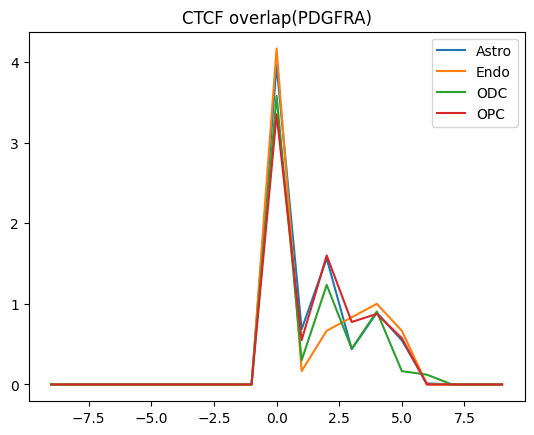

In [6]:
figure(preds, CTCF, 'CTCF overlap(PDGFRA)')

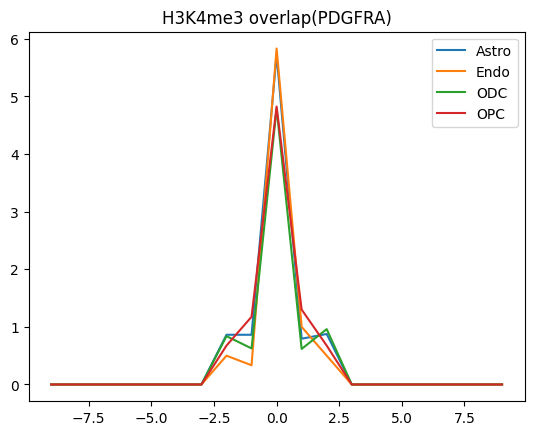

In [7]:
figure(preds, H3K4me3, 'H3K4me3 overlap(PDGFRA)')

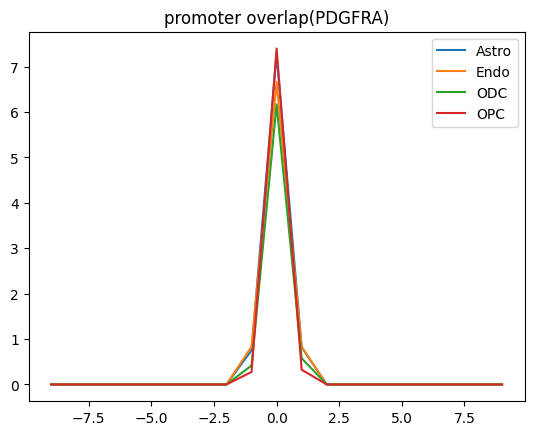

In [8]:
figure(preds, [55090000, 55120000, 55130000, 55150000], 'promoter overlap(PDGFRA)')